In [1]:
#YOLOv2 lightweight implementation based on: https://github.com/experiencor/keras-yolo2

#Imports and GPU configuration:
from keras import backend as K
from keras import layers 
from keras import models 
from keras import optimizers
from keras.utils import Sequence
from keras.applications.mobilenet import MobileNet  
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers import Conv2D, SeparableConv2D, BatchNormalization, LeakyReLU, Input, Lambda, Reshape

import os
import io
import PIL  
import cv2
import copy
import time
import h5py
import keras
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt 
import xml.etree.ElementTree as ET

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(tf.__version__, keras.__version__)

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5232761767002161625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 711327744
locality {
  bus_id: 1
}
incarnation: 6137285264501482943
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
1.5.0 2.2.0


In [2]:
#Setting up variables:
LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13 , 13
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

NO_OBJECT_SCALE  = 0.5
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 24
WARM_UP_BATCHES  = 3
TRUE_BOX_BUFFER  = 50

In [ ]:
#Setting pre-trained convolutional base:
conv_base=MobileNet(input_shape=(224,224,3), include_top=False, weights='imagenet')
conv_base.summary()

In [4]:
#Defining the detection model:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

x = conv_base(input_image)

x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)

x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), padding='same', activation='linear')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
output = Lambda(lambda args: args[0])([output, true_boxes])

conv_base.trainable = True

model = models.Model([input_image, true_boxes], output)

# Initializing the weights of the detection layer: 
layer = model.layers[-4]
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])
        
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Model)      multiple             3228864     input_2[0][0]                    
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 13, 13, 1024) 1057792     mobilenet_1.00_224[1][0]         
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 13, 13, 1024) 4096        separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
leaky_re_l

In [5]:
#Defining YOLO loss function:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [6]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

#MobileNet normalization function:
def normalize(image):
    image = image / 255.
    image = image - 0.5
    image = image * 2.

    return image

In [10]:
#Parsing annotations to construct train generator and validation generator:
voc_path ='/media/eHD/datasets/pascalVOC2012/VOCtrain/VOC2012/'
train_ids = get_ids(voc_path, train_set)
val_ids = get_ids(voc_path, val_set)
train_ids_2007 = get_ids('/media/eHD/datasets/pascalVOC2007/VOC_train/', sets_from_2007)

train_imgs_2007, seen_train_labels_2007 = parse_annotation('/media/eHD/datasets/pascalVOC2007/VOC_train/', 
                                                           '/media/eHD/datasets/pascalVOC2007/VOC_train/JPEGImages/', 
                                                           train_ids_2007, labels=LABELS)
train_imgs_2012, seen_train_labels_2012 = parse_annotation(voc_path, '/media/eHD/datasets/pascalVOC2012/VOCtrain/VOC2012/JPEGImages/', 
                                                           train_ids, labels=LABELS)
train_imgs=train_imgs_2007+train_imgs_2012
valid_imgs, seen_valid_labels = parse_annotation(voc_path, '/media/eHD/datasets/pascalVOC2012/VOCtrain/VOC2012/JPEGImages/', 
                                                 val_ids, labels=LABELS)

train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

print(len(train_imgs_2007))
print(len(train_imgs_2012))
print(len(train_imgs))
print(len(valid_imgs))
print(len(train_batch))
print(len(valid_batch))

5011
5717
10728
5823
447
243


In [19]:
#Setting callbacks and training:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-7)

checkpoint = ModelCheckpoint('/media/eHD/leticia/models/test13.{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=5)

tb_counter  = len([log for log in os.listdir('/media/eHD/leticia/logs/') if 'voc_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'voc_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)
 
sgd = optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
model.compile(optimizer=sgd, loss=custom_loss) 

history=model.fit_generator(generator= train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint, tensorboard, reduce_lr])

model.save('/media/eHD/leticia/models/test13.h5')

Epoch 1/100
447/447 [==============================] - 323s 722ms/step - loss: 5.4419 - val_loss: 4.9341
Epoch 2/100
447/447 [==============================] - 317s 708ms/step - loss: 4.7359 - val_loss: 4.5649
Epoch 3/100
447/447 [==============================] - 317s 710ms/step - loss: 4.4326 - val_loss: 4.4415
Epoch 4/100
447/447 [==============================] - 319s 713ms/step - loss: 4.2575 - val_loss: 4.2258
Epoch 5/100
447/447 [==============================] - 318s 712ms/step - loss: 4.1459 - val_loss: 4.0868

Epoch 00005: saving model to /media/eHD/leticia/models/test12.h5
Epoch 6/100
447/447 [==============================] - 315s 705ms/step - loss: 4.0170 - val_loss: 4.0116
Epoch 7/100
447/447 [==============================] - 319s 713ms/step - loss: 3.9506 - val_loss: 3.9929
Epoch 8/100
447/447 [==============================] - 316s 706ms/step - loss: 3.8752 - val_loss: 3.8875
Epoch 9/100
447/447 [==============================] - 318s 711ms/step - loss: 3.8250 - val_lo

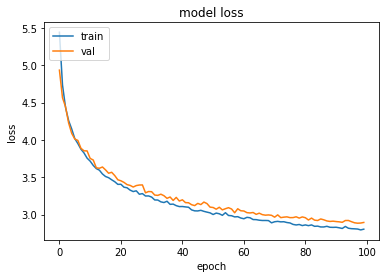

In [20]:
# test13
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-7)

checkpoint = ModelCheckpoint('/media/eHD/leticia/models/test13.{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=5)

tb_counter  = len([log for log in os.listdir('/media/eHD/leticia/logs/') if 'voc_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'voc_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)
 
sgd = optimizers.SGD(lr=1e-4, decay=0.0005, momentum=0.9)
model.compile(optimizer=sgd, loss=custom_loss) 

history=model.fit_generator(generator= train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint, tensorboard, reduce_lr])

model.save('/media/eHD/leticia/models/test14.h5')

Epoch 1/100
447/447 [==============================] - 326s 729ms/step - loss: 5.2692 - val_loss: 4.7884
Epoch 2/100
447/447 [==============================] - 320s 715ms/step - loss: 4.3819 - val_loss: 4.2030
Epoch 3/100
447/447 [==============================] - 320s 715ms/step - loss: 4.0399 - val_loss: 4.0299
Epoch 4/100
447/447 [==============================] - 322s 720ms/step - loss: 3.8034 - val_loss: 3.7156
Epoch 5/100
447/447 [==============================] - 322s 721ms/step - loss: 3.6688 - val_loss: 3.6090

Epoch 00005: val_loss improved from inf to 3.60899, saving model to /media/eHD/leticia/models/test13.05-3.61.h5
Epoch 6/100
447/447 [==============================] - 320s 715ms/step - loss: 3.5201 - val_loss: 3.5038
Epoch 7/100
447/447 [==============================] - 324s 725ms/step - loss: 3.4219 - val_loss: 3.4496
Epoch 8/100
447/447 [==============================] - 321s 718ms/step - loss: 3.3418 - val_loss: 3.3576
Epoch 9/100
447/447 [==========================

447/447 [==============================] - 323s 723ms/step - loss: 2.2223 - val_loss: 2.2892

Epoch 00065: val_loss improved from 2.31839 to 2.28919, saving model to /media/eHD/leticia/models/test13.65-2.29.h5
Epoch 66/100
447/447 [==============================] - 322s 720ms/step - loss: 2.2006 - val_loss: 2.2849
Epoch 67/100
447/447 [==============================] - 320s 716ms/step - loss: 2.1957 - val_loss: 2.2696
Epoch 68/100
447/447 [==============================] - 319s 714ms/step - loss: 2.2075 - val_loss: 2.2701
Epoch 69/100
447/447 [==============================] - 322s 720ms/step - loss: 2.2092 - val_loss: 2.2637
Epoch 70/100
447/447 [==============================] - 321s 718ms/step - loss: 2.1971 - val_loss: 2.2601

Epoch 00070: val_loss improved from 2.28919 to 2.26006, saving model to /media/eHD/leticia/models/test13.70-2.26.h5
Epoch 71/100
447/447 [==============================] - 320s 717ms/step - loss: 2.2020 - val_loss: 2.2598
Epoch 72/100
447/447 [===============

In [ ]:
# test14: noobj_scale=0,5
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

In [ ]:
WARM_UP_BATCHES  = 0

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-7)

checkpoint = ModelCheckpoint('/media/eHD/leticia/models/test14.{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=5)

tb_counter  = len([log for log in os.listdir('/media/eHD/leticia/logs/') if 'voc_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('~/logs/') + 'voc_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)
 
sgd = optimizers.SGD(lr=1e-5, decay=0.0005, momentum=0.9)
model.compile(optimizer=sgd, loss=custom_loss) 

history=model.fit_generator(generator= train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 100, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint, tensorboard, reduce_lr])

model.save('/media/eHD/leticia/models/test15.h5')

In [ ]:
# test15
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss') 
plt.xlabel('epoch') 
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

In [ ]:
os.listdir('/media/eHD/leticia/models/')

In [ ]:
import shutil
import os
source = os.listdir("/home/letica/")
destination = "/media/eHD/leticia/models/"
for files in source:
    if files.endswith(".h5"):
        shutil.move(files,destination)

In [ ]:
#Loading a trained model:
from keras.models import load_model
from keras.utils.generic_utils import CustomObjectScope

def relu6(x):
    return K.relu(x, max_value=6)

true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

with CustomObjectScope({'relu6':relu6, 'custom_loss':custom_loss}):
    model = load_model('/media/eHD/leticia/models/test10.h5')
    
model.summary()

In [ ]:
weights=model.get_weights()

In [10]:
#Parsing annotations to construct test generator:
test_path = '/media/eHD/datasets/pascalVOC2007/VOC_test/'
test_ids = get_ids(test_path, test_set)
test_imgs, seen_test_labels = parse_annotation(test_path, 
                                               '/media/eHD/datasets/pascalVOC2007/VOC_test/JPEGImages/', 
                                                test_ids, labels=LABELS)

test_batch = BatchGenerator(test_imgs, generator_config, norm=normalize, jitter=False)

print(len(test_imgs))
print(len(test_batch))

4952
207


In [ ]:
#Evaluating the model on test dataset:
results = model.evaluate_generator(test_batch, 
                                   steps=len(test_batch)) 

print('Final test loss:', (results))

In [ ]:
#Compute average precision:
average_precisions = evaluate(test_batch)     

for label, average_precision in average_precisions.items():
    print(LABELS[label], '{:.4f}'.format(average_precision))
print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))         

In [ ]:
#Performing detection on an image:
image = cv2.imread('/media/eHD/datasets/pascalVOC2012/VOCtrain/VOC2012/JPEGImages/2009_003369.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

time_start = time.clock()
netout = model.predict([input_image, dummy_array])
time_elapsed = (time.clock() - time_start)
print('Time in ms:', time_elapsed*1000 )

boxes = decode_netout(netout[0], 
                      obj_threshold=0.0255,
                      nms_threshold=NMS_THRESHOLD,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [7]:
sets_from_2007 = [('2007', 'train'), ('2007', 'val')]
train_set = [('2012', 'train')]
val_set = [('2012', 'val')]
test_set = [('2007', 'test')]

def get_ids(voc_path, datasets):
    """Get image identifiers for corresponding list of dataset identifies.
    code originally from https://github.com/allanzelener/YAD2K
    Parameters
    ----------
    voc_path : str
        Path to VOCdevkit directory.
    datasets : list of str tuples
        List of dataset identifiers in the form of (year, dataset) pairs.
    Returns
    -------
    ids : list of str
        List of all image identifiers for given datasets.
    """
    ids = []
    for year, image_set in datasets:
        id_file = os.path.join(voc_path, 'ImageSets/Main/{}.txt'.format(image_set))
        with open(id_file, 'r') as image_ids:
            ids.extend(map(str.strip, image_ids.readlines()))
    return ids

def parse_annotation(ann_dir, img_dir, ids, labels=[]):
    all_imgs = []
    seen_labels = {}
      
    for image_id in sorted(ids):
        img = {'object':[]}
        
        fname = os.path.join(ann_dir, 'Annotations/{}.xml'.format(image_id))
        with open(fname) as in_file:
            tree = ET.parse(in_file)
        root = tree.getroot()
                            
        for elem in tree.iter():
            if 'filename' in elem.tag:
                img['filename'] = img_dir + elem.text
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

class BatchGenerator(Sequence):
    def __init__(self, images, 
                       config, 
                       shuffle=True, 
                       jitter=True, 
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self.aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                #iaa.Fliplr(0.5), # horizontally flip 50% of all images
                #iaa.Flipud(0.2), # vertically flip 20% of all images
                #sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    #translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    #rotate=(-5, 5), # rotate by -45 to +45 degrees
                    #shear=(-5, 5), # shear by -16 to +16 degrees
                    #order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    #cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
                # execute 0 to 5 of the following (less important) augmenters per image
                # don't execute all of them, as that would often be way too strong
                iaa.SomeOf((0, 5),
                    [
                        #sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges
                        #sometimes(iaa.OneOf([
                        #    iaa.EdgeDetect(alpha=(0, 0.7)),
                        #    iaa.DirectedEdgeDetect(alpha=(0, 0.7), direction=(0.0, 1.0)),
                        #])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            #iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        #iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        #iaa.Grayscale(alpha=(0.0, 1.0)),
                        #sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        #sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))) # sometimes move parts of the image around
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))   

    def num_classes(self):
        return len(self.config['LABELS'])

    def size(self):
        return len(self.images)    

    def load_annotation(self, i):
        annots = []

        for obj in self.images[i]['object']:
            annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
            annots += [annot]

        if len(annots) == 0: annots = [[]]

        return np.array(annots)

    def load_image(self, i):
        return cv2.imread(self.images[i]['filename'])

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))  # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))                # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        
                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell
                        
                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1
                        
                        shifted_box = BoundBox(0, 
                                               0,
                                               center_w,                                                
                                               center_h)
                        
                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)
                            
                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            # assign input image to x_batch
            if self.norm != None: 
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'], 
                                    (obj['xmin']+2, obj['ymin']+12), 
                                    0, 1.2e-3 * img.shape[0], 
                                    (0,255,0), 2)
                        
                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1  

        #print(' new batch created', idx)

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['filename']
        image = cv2.imread(image_name)

        if image is None: print('Cannot find ', image_name)

        h, w, c = image.shape
        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)
            
            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)
                
            image = self.aug_pipe.augment_image(image)            
            
        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)
                
            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)
                    
                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin
                
        return image, all_objs

In [8]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
            
        return self.score

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersect = intersect_w * intersect_h

    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = w1*h1 + w2*h2 - intersect
    
    return float(intersect) / union

def draw_boxes(image, boxes, labels):
    image_h, image_w, _ = image.shape

    for box in boxes:
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)

        cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (0,255,0), 3)
        print(labels[box.get_label()])
        cv2.putText(image, 
                    labels[box.get_label()] + ' ' + str(box.get_score()), 
                    (xmin, ymin - 13), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    1e-3 * image_h, 
                    (0,255,0), 2)
        
    return image          
        
def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
    grid_h, grid_w, nb_box = netout.shape[:3]

    boxes = []
    
    # decode the output by the network
    netout[..., 4]  = _sigmoid(netout[..., 4])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    print(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_threshold
    
    for row in range(grid_h):
        for col in range(grid_w):
            for b in range(nb_box):
                # from 4th element onwards are confidence and class classes
                classes = netout[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row,col,b,:4]

                    x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
                    y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
                    confidence = netout[row,col,b,4]
                    
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    
                    boxes.append(box)

    # suppress non-maximal boxes
    for c in range(nb_class):
        sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].classes[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                        boxes[index_j].classes[c] = 0
                        
    # remove the boxes which are less likely than a obj_threshold
    boxes = [box for box in boxes if box.get_score() > obj_threshold]
    
    return boxes    

def compute_overlap(a, b):
    """
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua  
    
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap      
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3          

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)

In [9]:
    def evaluate(generator, 
                 iou_threshold=0.3,
                 score_threshold=0.3,
                 max_detections=100,
                 save_path=None):
        """ Evaluate a given dataset using a given model.
        code originally from https://github.com/fizyr/keras-retinanet
        # Arguments
            generator       : The generator that represents the dataset to evaluate.
            model           : The model to evaluate.
            iou_threshold   : The threshold used to consider when a detection is positive or negative.
            score_threshold : The score confidence threshold to use for detections.
            max_detections  : The maximum number of detections to use per image.
            save_path       : The path to save images with visualized detections to.
        # Returns
            A dict mapping class names to mAP scores.
        """    
        # gather all detections and annotations
        all_detections     = [[None for i in range(generator.num_classes())] for j in range(generator.size())]
        all_annotations    = [[None for i in range(generator.num_classes())] for j in range(generator.size())]

        for i in range(generator.size()):
            raw_image = generator.load_image(i)
            raw_height, raw_width, raw_channels = raw_image.shape

            # make the boxes and the labels
            pred_boxes  = predict(raw_image)

            score = np.array([box.score for box in pred_boxes])
            pred_labels = np.array([box.label for box in pred_boxes])        
            
            if len(pred_boxes) > 0:
                pred_boxes = np.array([[box.xmin*raw_width, box.ymin*raw_height, box.xmax*raw_width, box.ymax*raw_height, box.score] for box in pred_boxes])
            else:
                pred_boxes = np.array([[]])  
            
            # sort the boxes and the labels according to scores
            score_sort = np.argsort(-score)
            pred_labels = pred_labels[score_sort]
            pred_boxes  = pred_boxes[score_sort]
            
            # copy detections to all_detections
            for label in range(generator.num_classes()):
                all_detections[i][label] = pred_boxes[pred_labels == label, :]
                
            annotations = generator.load_annotation(i)
            
            # copy detections to all_annotations
            for label in range(generator.num_classes()):
                all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()
                
        # compute mAP by comparing all detections and all annotations
        average_precisions = {}
        
        for label in range(generator.num_classes()):
            false_positives = np.zeros((0,))
            true_positives  = np.zeros((0,))
            scores          = np.zeros((0,))
            num_annotations = 0.0

            for i in range(generator.size()):
                detections           = all_detections[i][label]
                annotations          = all_annotations[i][label]
                num_annotations     += annotations.shape[0]
                detected_annotations = []

                for d in detections:
                    scores = np.append(scores, d[4])

                    if annotations.shape[0] == 0:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)
                        continue

                    overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                    assigned_annotation = np.argmax(overlaps, axis=1)
                    max_overlap         = overlaps[0, assigned_annotation]

                    if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                        false_positives = np.append(false_positives, 0)
                        true_positives  = np.append(true_positives, 1)
                        detected_annotations.append(assigned_annotation)
                    else:
                        false_positives = np.append(false_positives, 1)
                        true_positives  = np.append(true_positives, 0)

            # no annotations -> AP for this class is 0 (is this correct?)
            if num_annotations == 0:
                average_precisions[label] = 0
                continue

            # sort by score
            indices         = np.argsort(-scores)
            false_positives = false_positives[indices]
            true_positives  = true_positives[indices]

            # compute false positives and true positives
            false_positives = np.cumsum(false_positives)
            true_positives  = np.cumsum(true_positives)

            # compute recall and precision
            recall    = true_positives / num_annotations
            precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

            # compute average precision
            average_precision  = compute_ap(recall, precision)  
            average_precisions[label] = average_precision

        return average_precisions    

    def predict(image):
        image_h, image_w, _ = image.shape
        image = cv2.resize(image, (IMAGE_H, IMAGE_W))
        image = normalize(image)

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)
        dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

        netout = model.predict([input_image, dummy_array])[0]
        boxes  = decode_netout(netout, ANCHORS, CLASS)

        return boxes